# Two-qubit Transverse field Ising model by a quantum neural state



<img src="../logo_circular.png" width="20" height="20" />@by claudio<br>
nonlinearxwaves@gmail.com<br>


@created 30 july 2022<br>
@version 4 sept 2022

In [1]:
from thqml import quantummap as quantummap
import tensorflow as  tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
np.set_printoptions(precision=2)

2022-09-05 06:58:44.882332: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-05 06:58:44.882360: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-09-05 06:58:46.252987: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-05 06:58:46.253013: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-05 06:58:46.253034: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (x1): /proc/driver/nvidia/version does not exist
2022-09-05 06:58:46.253307: I tensorflow/core/platform/cpu_feature_guard.c

# Define Hamiltonian operator

$\hat{\mathcal{H}}=-J Z_0 Z_1 -h_0 Z_0 -h_1 Z_1$

In [2]:
@tf.function
def Hamiltonian(J=1, h=[0,0]):
    """ Two-qubit tranverse Ising model Hamiltonian
    
        H=-J Z0 Z1 -h0 X0 -h1 X0
        
        Params
        ------
        J = coupling shape=(1,)
        h = field shape=(2,)
    """
    out = -J*quantummap.ZZ-h[0]*quantummap.XI-h[1]*quantummap.IX
        
    return out

## Test the Hamiltonian

Hamiltonian with no field terms

In [3]:
H=Hamiltonian()
print(quantummap.Transform2Matrix(H))

tf.Tensor(
[[-1.+0.j -0.+0.j -0.+0.j -0.+0.j]
 [-0.+0.j  1.-0.j -0.+0.j -0.+0.j]
 [-0.+0.j -0.+0.j  1.-0.j -0.+0.j]
 [-0.+0.j -0.+0.j -0.+0.j -1.+0.j]], shape=(4, 4), dtype=complex64)


Hamiltonian with field terms

In [4]:
H=Hamiltonian(h=[1.1,3.2])
print(quantummap.Transform2Matrix(H))

tf.Tensor(
[[-1. +0.j -3.2+0.j -1.1+0.j -0. +0.j]
 [-3.2+0.j  1. -0.j -0. +0.j -1.1+0.j]
 [-1.1+0.j -0. +0.j  1. -0.j -3.2+0.j]
 [-0. +0.j -1.1+0.j -3.2+0.j -1. +0.j]], shape=(4, 4), dtype=complex64)


# Custom Neural weight

In [5]:
class HamiltonianLayerNNQS(tf.keras.layers.Layer):
    # Define a Layer returning the mean value of the Hamiltonian
    # on the variational ansatz
    #
    # The layer uses quantum neural networks
    # formed by two dense layers with 
    # relu activation
    #
    # The Layer use the function
    # Hamiltonian
    #
    # The constructor use parameters 
    #
    #  Params
    #  ------
    #  J : coupling coefficient
    #      (default J=1)
    #  h : positive field shape=(2,)
    #      (default h=[0.0,0.0])
    #  nhidden: the number of internal layers
    #      (default is 16)
    #  bias: the bias state
    #      (default is ground state quantummap.q00)
    #
    #  Example
    #  -------
    #  HL=HL(J=.5, h=[1.2,-1.0], nhidden=100)
    #
    #  Returns
    #  -------
    #  The call return the real part of 
    #  <\psi|H|\psi>
    #
    def __init__(self, J=1.0, h=[0.0,0.0], 
                 nhidden=10,
                 bias=quantummap.q00,
                 **kwargs):
        super(HamiltonianLayerNNQS, self).__init__(**kwargs)
        # trainable parameter of the model
        # gap coefficient
        self.J=J
        # field coefficient
        self.h=h
        # Hamiltonian
        self.H=Hamiltonian(J=self.J,h=self.h)
        # Bias state
        self.bias=bias
        # Weights of the NNQS
        self.AR=tf.Variable(tf.random.normal(shape=(nhidden,8)));
        self.AI=tf.Variable(tf.random.normal(shape=(nhidden,8))); 
        self.HR=tf.Variable(tf.random.normal(shape=(4,nhidden)));
        self.HI=tf.Variable(tf.random.normal(shape=(4,nhidden))); 
        
    @tf.function
    def realNNQS(self,bias):
        """ Function returning 
        the real part NN

        Input
        -----
        bias state shape=(2,2)
        
        Returns
        -------
        real phi shape=(4,)        
        """
        rebias=tf.math.real(bias)
        imbias=tf.math.imag(bias)
        bias1=tf.concat([rebias,imbias],0)
        bias2=tf.reshape(bias1,[-1])
        hideR=tf.nn.relu(tf.tensordot(self.AR,bias2,axes=1))
        rephi=tf.nn.relu(tf.tensordot(self.HR,hideR,axes=1))
        return rephi

    @tf.function
    def imagNNQS(self,bias):
        """ Function returning 
        the imaginary part NN
        
        Input
        -----
        bias state shape=(2,2)
        
        Returns
        -------
        imag phi shape=(4,)
        """
        rebias=tf.math.real(bias)
        imbias=tf.math.imag(bias)
        bias1=tf.concat([rebias,imbias],0)
        bias2=tf.reshape(bias1,[-1])
        hideI=tf.nn.relu(tf.tensordot(self.AI,bias2,axes=1))
        imphi=tf.nn.relu(tf.tensordot(self.HI,hideI,axes=1))
        return imphi

    @tf.function
    def complexify(self,rephi,imphi):
        """ Function combining
        real and imaginary part
        and normalizing
        """
        cphi0=tf.complex(rephi,imphi)
        cphi=tf.reshape(cphi0,[2,2])
        sqrtnorm=tf.math.sqrt(quantummap.Scalar(cphi,cphi))
        nphi=cphi/sqrtnorm
        return nphi

    @tf.function
    def ground_state(self):
        """ Return the current ground state"""
        rph=self.realNNQS(self.bias)
        iph=self.imagNNQS(self.bias)        
        return self.complexify(rph,iph)

    def call(self,dummy):
        """ Return Re<H> 
        Remark:  this layer has a dummy variable as input
        (required for compatibility with tensorflow call)
        """
        phi=self.ground_state()
        Hphi=quantummap.Gate2(self.H,phi)
        meanH=tf.math.real(quantummap.Scalar(phi, Hphi))
        return meanH

## Test the layer

Create the layer with default parameters

In [6]:
HL=HamiltonianLayerNNQS()

Print J and H

In [7]:
print(HL.J, HL.h)

1.0 ListWrapper([0.0, 0.0])


Display $\mathcal{\hat{H}}$ as a matrix

In [8]:
print(quantummap.Transform2Matrix(HL.H))

tf.Tensor(
[[-1.+0.j -0.+0.j -0.+0.j -0.+0.j]
 [-0.+0.j  1.-0.j -0.+0.j -0.+0.j]
 [-0.+0.j -0.+0.j  1.-0.j -0.+0.j]
 [-0.+0.j -0.+0.j -0.+0.j -1.+0.j]], shape=(4, 4), dtype=complex64)


In [9]:
HL.bias

<tf.Tensor: shape=(2, 2), dtype=complex64, numpy=
array([[1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j]], dtype=complex64)>

Display the current ground state

In [10]:
print(HL.ground_state())

tf.Tensor(
[[0.+0.j 0.+0.j]
 [1.+0.j 0.+0.j]], shape=(2, 2), dtype=complex64)


Check the normalizzation

In [11]:
quantummap.Scalar(HL.ground_state(),HL.ground_state())

<tf.Tensor: shape=(1, 1), dtype=complex64, numpy=array([[1.+0.j]], dtype=complex64)>

Compute $\mathcal{\hat{H}}|\phi\rangle$

In [12]:
Hphi=quantummap.Gate2(HL.H,HL.ground_state())

Compute $\langle \phi|\mathcal{\hat{H}}|\phi\rangle$

In [13]:
quantummap.Scalar2(HL.ground_state(),Hphi)

<tf.Tensor: shape=(1, 1), dtype=complex64, numpy=array([[1.+0.j]], dtype=complex64)>

Call the layer and check is equal to $\langle \phi|\mathcal{\hat{H}}|\phi\rangle$

In [14]:
HL(1.0)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.]], dtype=float32)>

# Define and train the model

In [15]:
# bias
Hbias=quantummap.Gate2(quantummap.HH,quantummap.q00)
# hyperparameter for the Hamiltonian
J=1.0
h=[1.0,1.0]
# Input layer (one dummy input)
xin = tf.keras.layers.Input(1,name='DummyInput');
# Hamiltonianl layer
HL=HamiltonianLayerNNQS(J=J,h=h, bias=Hbias,nhidden=100, name='HL')
# output
meanH=HL(xin)
# trainable model returning meanH
IsingNNQS = tf.keras.Model(inputs = xin, outputs=meanH, name='modelNNQS')
# add loss function for the mean energy
IsingNNQS.add_loss(meanH)

## Test the model with dummy input

In [17]:
tf.print(IsingNNQS(1.1))

[[-0.104926467]]


## Summary of the model

In [18]:
IsingNNQS.summary()

Model: "modelNNQS"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 DummyInput (InputLayer)     [(None, 1)]               0         
                                                                 
 HL (HamiltonianLayerNNQS)   (1, 1)                    2400      
                                                                 
 add_loss (AddLoss)          (1, 1)                    0         
                                                                 
Total params: 2,400
Trainable params: 2,400
Non-trainable params: 0
_________________________________________________________________


## Plot model

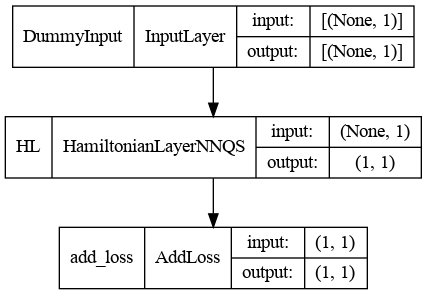

In [20]:
from keras.utils.vis_utils import plot_model
# save as pdf
plot_model(IsingNNQS, to_file='TwoQubitIsingNNQS_plot.pdf', show_shapes=True, show_layer_names=True)
# save and display as png
plot_model(IsingNNQS, to_file='TwoQubitIsingNNQS_plot.png', show_shapes=True, show_layer_names=True)

## Store the ground state before training

In [ ]:
ground_state_0=tf.identity(HL10.ground_state())
print(ground_state_0)

## Store the weights before training

In [ ]:
weight0=IsingNNQS10.weights

## Train

In [ ]:
# initialize tqdm callback with default parameters
import tqdm
tqdm_callback = tfa.callbacks.TQDMProgressBar(leave_epoch_progress=False, show_epoch_progress=False)

We compile the model

In [ ]:
IsingNNQS10.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1))

We use the <code>tqdm_callback</code> to display the error bar while training

In [ ]:
historyNNQS10 = IsingNNQS10.fit(x=np.zeros(10,),epochs=1000, verbose=0, callbacks=[tqdm_callback])

Print last value of energy

In [ ]:
historyNNQS10.history['loss'][-1]

In [ ]:
IsingNNQS10(1.0)

### eigenvalues

In [ ]:
es=tf.linalg.eig(quantummap.Transform2Matrix(HL10.H))
print(es[0])
# find the lowest eigenvalue
esmin=np.min(tf.math.real(es[0].numpy()))
print("Lowest eigenvalues "+repr(esmin))

**REMARK** the lowest energy value is higher than the ground state energy !

## Plot the training history

In [ ]:
# %%
# %matplotlib inline
# Plot training & validation accuracy values
f1 = plt.figure
plt.subplot(2, 1, 1)
plt.plot(historyNNQS10.history['loss'])
plt.ylabel('$<\mathcal{\hat{H}}>$')
plt.xlabel('Epoch')
# superimpose the lowest eigenvalue
xline=np.linspace(0,1000,100);
yline=esmin*np.ones_like(xline);
plt.plot(xline,yline,'r--')
#print the training hystory on a file
#plt. savefig("trainingTwoQuibtModelIsingNNQS10oknhidden100Hq00.pdf", format="pdf", bbox_inches="tight")

### Compute the entropy of the ground state

In [ ]:
quantummap.VonNeumannEntropy2(HL10.ground_state())

In [ ]:
HL10.ground_state()

In [ ]:
ground_state_0

Check normalizzation of the ground state

In [ ]:
quantummap.Scalar(HL10.ground_state(),HL10.ground_state())

Stop running the notebook

In [ ]:
assert False